In [7]:
!pip install -U gensim

  Using cached gensim-3.8.3-cp37-cp37m-macosx_10_9_x86_64.whl (24.2 MB)
     |████████████████████████████████| 119 kB 2.8 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-4.2.0-py3-none-any.whl size=109630 sha256=160f5c088d80c483d830724bd37c45611e4c08cd761e519a0e2de9a9e19ad414
  Stored in directory: /Users/ltaing/Library/Caches/pip/wheels/25/88/e3/7cd51a6379cac37213cac47545a27688782752ff66351b953d
Successfully built smart-open


In [82]:
import numpy as np 
import pandas as pd 
import string
import re
from pprint import pprint
from time import time

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_curve

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import joblib

import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

## Pipeline Joblib

In [9]:
from joblib import dump, load
import joblib

pipeline = joblib.load('./sentiment_pipe.joblib')
print(pipeline)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', SVC(C=1000, gamma=0.001))])


## Performance Model

In [10]:
from joblib import dump, load
import pandas as pd
 
df = pd.read_csv("comments_train.csv")
base_model = load('sentiment_pipe.joblib')

y_test = df["sentiment"].apply(lambda x: 1 if x=="Positive" else 0).values
y_pred = base_model.predict(df["comment"].values)
 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.26      0.39       598
           1       0.69      0.95      0.80      1019

    accuracy                           0.70      1617
   macro avg       0.72      0.61      0.59      1617
weighted avg       0.71      0.70      0.65      1617



In [11]:
df = pd.read_csv('/Users/ltaing/Documents/SIMPLON DATA IA/TITRE PRO/CP_1/API-REST-FLASK-V2/app/model/comments_train.csv')
print(df)

                                                comment sentiment
0     J'ai réservé ma table quelques mois à l'avance...  Positive
1     Que dire... Nicolas sale est un chef d excepti...  Positive
2     Dans une rue tranquille non loin du Panthéon u...  Positive
3     Rien à redire le restaurant est irréprochablem...  Positive
4     Comme avec les autres commentaires nos repas é...  Positive
...                                                 ...       ...
1612  Le service a été rapide et les crêpes très bon...  Positive
1613  Restaurant excellent bon rapport qualité-prix ...  Positive
1614  Incroyable mais vrai 190€ la baguette ! Que di...  Negative
1615  Un japonais assez chic des beaux quartiers. No...  Positive
1616  Accueil très chaleureux avec un personnel jeun...  Positive

[1617 rows x 2 columns]


<AxesSubplot:ylabel='sentiment'>

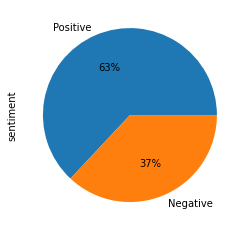

In [12]:
df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

## Data Preprocessing    

Text Cleaning

Before we start using the tweets’ text we need to clean it. We’ll do the this in the class CleanText. With this class we’ll perform the following actions:

    remove the mentions.
    remove the hash tag sign (#) but not the actual tag as this may contain information
    set all words to lowercase
    remove all punctuations, including the question and exclamation marks
    remove the URLs as they do not contain useful information. We did not notice a difference in the number of URLs used between the sentiment classes
    make sure to convert the emojis into one word.
    remove digits
    remove stopwords
    apply the PorterStemmer to keep the stem of the words

In [18]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)    
    
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('french')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["non", "jamais", "bien"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [19]:
ct = CleanText()
sr_clean = ct.fit_transform(df.comment)
sr_clean.sample(5)

1154    petit halt déjeuner aprè visit exposit grand p...
462     accueil inadmiss vendeus aprè midi connaît ni ...
1352    bon frai innov revanch pu profit tabl soleil s...
1121    consommé truff blanch dont oublierai somptueus...
988     déjeuner entr collègu bien agréabl servic atte...
Name: comment, dtype: object

One side-effect of text cleaning is that some rows do not have any words left in their text. For the CountVectorizer and TfIdfVectorizer this does not pose a problem. Yet, for the Word2Vec algorithm this causes an error. There are different strategies to deal with these missing values.

    Remove the complete row, but in a production environment this is not desirable.
    Impute the missing value with some placeholder text like *[no_text]*
    When applying Word2Vec: use the average of all vectors

In [39]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


In [40]:
#df['clean_text'] = sr_clean
#df.columns.tolist()

['comment', 'sentiment', 'clean_text']

In [41]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols    
        
    def transform(self, X, **transform_params):
        return X[self.cols]  
    
    def fit(self, X, y=None, **fit_params):
        return self

## Hyperparameter tuning and cross-validation + Evaluation metrics

In [57]:
X = df['comment']
y = df["sentiment"].apply(lambda x: 1 if x=="Positive" else 0).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In our function grid_vectwe additionally generate the classification_report on the test data. This provides some interesting metrics per target class. This might be more appropriate here. These metrics are the precision, recall and F1 score.

    Precision: Of all rows we predicted to be a certain class, how many did we correctly predict?
    Recall: Of all rows of a certain class, how many did we correctly predict?
    F1 score: Harmonic mean of Precision and Recall.

With the elements of the confusion matrix we can calculate Precision and Recall.

In [76]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    features = FeatureUnion([('pipe', Pipeline([('vect', vect)]))]
                                , n_jobs=-1)    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'roc_auc', cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)    
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()    
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

## Parameter grids for GridSearchCV

In [77]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2),
    'features__pipe__vect__max_features': (1000,1500,2000,2500)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Parameter grid settings for SVC
parameters_svc = {
    'clf__C': [1, 10, 100,1000], 
    'clf__gamma': [1,0.1,0.01,0.001],
    'clf__kernel': ['rbf', 'poly', 'sigmoid']
}

In [78]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

print(lr.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [79]:
from sklearn.svm import SVC

svc = SVC()

print(svc.get_params().keys())

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])


## Classifiers

In [80]:
mnb = MultinomialNB()
logreg = LogisticRegression()
svc = SVC()

 ## CountVectorizer

In [81]:
countvect = CountVectorizer(stop_words=stopwords.words('french')) #token_pattern=r'\b\w+\b',

# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_mnb_countvect, './output/best_mnb_countvect.joblib')

# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, './output/best_logreg_countvect.joblib')

# SVC
best_logreg_countvect = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, './output/best_svc_countvect.joblib')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (1000, 1500, 2000, 2500),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done in 12.405s

Best CV score: 0.949
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__max_features: 2500
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.858


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       122
           1       0.87      0.91      0.89       202

    accuracy                           0.86       324
   macro avg       0.85      0.84      0.85       324
weighted avg       0.86      0.86      0.86   

['./output/best_svc_countvect.joblib']

In [84]:
from joblib import dump, load
import joblib

pipeline = joblib.load('./output/best_mnb_countvect.joblib')
print(pipeline)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(n_jobs=-1,
                                                     transformer_list=[('pipe',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(stop_words=['au',
                                                                                                                     'aux',
                                                                                                                     'avec',
                                                                                                                     'ce',
                                                                                                                     'ces',
                                                                     

In [56]:
countvect = CountVectorizer()

# MultinomialNB
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_mnb_countvect, './output/best_mnb_countvect.pkl')

# LogisticRegression
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, './output/best_logreg_countvect.pkl')

# SVC
best_logreg_countvect = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, './output/best_svc_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 6.031s

Best CV score: 0.890
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.895


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        68
           1       0.89      0.94      0.91        94

    accuracy                           0.90       162
   macro avg       0.90      0.89      0.89       162
weighted avg       0.90      0.90      0.89       162

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 '

['./output/best_svc_countvect.pkl']

## TF-IDF Vectorizer

In [83]:
tfidfvect = TfidfVectorizer(stop_words=stopwords.words('french'))

# MultinomialNB
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_mnb_tfidf, './output/best_mnb_tfidf.joblib')

# LogisticRegression
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
joblib.dump(best_logreg_tfidf, './output/best_logreg_tfidf.joblib')

# SVC
best_logreg_countvect = grid_vect(svc, parameters_svc, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
joblib.dump(best_logreg_countvect, './output/best_svc_countvect.joblib')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_features': (1000, 1500, 2000, 2500),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 144 candidates, totalling 720 fits
done in 10.796s

Best CV score: 0.950
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__max_features: 2500
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.843


Classification Report Test Data
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       122
           1       0.83      0.94      0.88       202

    accuracy                           0.84       324
   macro avg       0.85      0.81      0.82       324
weighted avg       0.85      0.84      0.84   

['./output/best_svc_countvect.joblib']

In [64]:
from joblib import dump, load
import joblib

pipeline = joblib.load('./output/best_mnb_tfidf.joblib')
print(pipeline)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(n_jobs=-1,
                                                     transformer_list=[('pipe',
                                                                        Pipeline(steps=[('vect',
                                                                                         TfidfVectorizer(max_df=0.8,
                                                                                                         max_features=2500,
                                                                                                         min_df=7,
                                                                                                         stop_words=['au',
                                                                                                                     'aux',
                                                                                     

## Word2Vec

In [ ]:
SIZE = 50

X_train['clean_text_wordlist'] = X_train.clean_text.apply(lambda x : word_tokenize(x))
X_test['clean_text_wordlist'] = X_test.clean_text.apply(lambda x : word_tokenize(x))

model = gensim.models.Word2Vec(X_train.clean_text_wordlist
, min_count=1
, size=SIZE
, window=5
, workers=4)

model.most_similar('plane', topn=3)

In [ ]:
def compute_avg_w2v_vector(w2v_dict, tweet):
    list_of_word_vectors = [w2v_dict[w] for w in tweet if w in w2v_dict.vocab.keys()]
    
    if len(list_of_word_vectors) == 0:
        result = [0.0]*SIZE
    else:
        result = np.sum(list_of_word_vectors, axis=0) / len(list_of_word_vectors)
        
    return resultX_train_w2v = X_train['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))
X_test_w2v = X_test['clean_text_wordlist'].apply(lambda x: compute_avg_w2v_vector(model.wv, x))

In [ ]:
X_train_w2v = pd.DataFrame(X_train_w2v.values.tolist(), index= X_train.index)
X_test_w2v = pd.DataFrame(X_test_w2v.values.tolist(), index= X_test.index)# Concatenate with the TextCounts variables
X_train_w2v = pd.concat([X_train_w2v, X_train.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)
X_test_w2v = pd.concat([X_test_w2v, X_test.drop(['clean_text', 'clean_text_wordlist'], axis=1)], axis=1)

In [ ]:
best_logreg_w2v = grid_vect(logreg, parameters_logreg, X_train_w2v, X_test_w2v, is_w2v=True)
joblib.dump(best_logreg_w2v, './output/best_logreg_w2v.pkl')

## Pipeline Preprocessing + Model

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

In [103]:
#Use the key for the classifier followed by __ and the attribute

# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2),
    'features__pipe__vect__max_features': (1000,1500,2000,2500)
}
# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75),
    'clf__fit_prior': [True, False] 
}
# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2'),
    'clf__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'clf__max_iter': [20, 50, 100],
}

# Parameter grid settings for SVC
parameters_svc = {
    'clf__C': [1, 10, 100,1000], 
    'clf__gamma': [1,0.1,0.01,0.001],
    'clf__kernel': ['rbf', 'poly', 'sigmoid']
}

# Parameter grid settings for VotingClassifier
parameters_vc = {
    'lr__C': [0.25, 0.5, 1.0], 
    'lf__penalty': ['l1', 'l2'],
    'lr__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__max_iter': [20, 50, 100],
    'lr__multi_class': ['ovr','multinomial'],
    'mnb__alpha': [0.25, 0.5, 0.75],
    'mnb__fit_prior': [True, False],
    'gboost__n_estimator':[10,20],
    'gboost__loss':["deviance","exponential"],
    'gboost__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'gboost__min_samples_split': np.linspace(0.1, 0.5, 12),
    'gboost__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    'gboost__max_depth':[3,5,8],
    'gboost__max_features':["log2","sqrt"],
    'gboost__criterion': ["friedman_mse", "mse",  "mae"],
    'gboost__subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    'svm__C': [1, 10, 100,1000], 
    'svm__gamma': [1,0.1,0.01,0.001],
    'svm__kernel': ['rbf', 'poly', 'sigmoid'],
    'knn__n-neighbors':[1,2,3,4,5,6,7,8,9,10],
    'knn__weights':['distance', 'uniform'],
    'knn__p':[1,2],
    'rfc__n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'rfc__max_features': ['auto', 'sqrt'],
    'rfc__max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__bootstrap': [True, False],
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [104]:
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = SVC()
clf6 = KNeighborsClassifier()
clf7 = GradientBoostingClassifier()

tfidfvect = TfidfVectorizer(stop_words=stopwords.words('french'))
countvect = CountVectorizer(stop_words=stopwords.words('french')) #token_pattern=r'\b\w+\b',

In [117]:
bow_pipeline = Pipeline(
    steps=[("BOW", CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words=stopwords.words('french'))),
        ('Voting', VotingClassifier(estimators=[('Naive bayes complement', ComplementNB()),("Naive bayes multinomial", MultinomialNB()),("LR", LogisticRegression()), ("KNN",neighbors.KNeighborsClassifier(n_neighbors = 5,p=1,weights="distance")) ], voting='hard'))])

bow_pipeline.fit(X_pip_train, y_train)
y_pred = bow_pipeline.predict(X_test)


f1_s = f1_score(y_test, y_pred)
roc_s = roc_auc_score(y_test, y_pred)

print (grid.best_params_)
print('F1-score: ', f1_s)
print('Roc curve:', roc_pip)

NameError: name 'ComplementNB' is not defined

In [115]:
eclf1 = VotingClassifier(estimators=[
    ('lr', clf1), 
    ('rf', clf2), 
    ('gnb', clf3),
    ('mnb', clf4),
    ('svc', clf5),
    ('knn', clf6),
    ('gbc', clf7)
    ], voting='hard')

#eclf2 = VotingClassifier(estimators=[ 
#    ('lr', clf1), 
#    ('rf', clf2), 
#    ('gnb', clf3),
#    ('mnb', clf4),
#    ('svc', clf5),
#    ('knn', clf6),
#    ('gbc', clf7),
#    ], voting='soft')


grid = GridSearchCV(estimator=eclf1, param_grid=parameters_vc, scoring = 'roc_auc', cv=5)

grid.fit(X_train,y_train)
y_pred = grid.predict(X_test)

f1_s = f1_score(y_test, y_pred)
roc_s = roc_auc_score(y_test, y_pred)

print (grid.best_params_)
print('F1-score: ', f1_s)
print('Roc curve:', roc_pip)

MemoryError: 

In [109]:
#best_vc_tfidf = grid_vect(eclf1, parameters_vc, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)
#joblib.dump(best_vc_tfidf, './output/best_vc_tfidf.joblib')

In [110]:
#best_vc_tfidf = grid_vect(eclf1, parameters_vc, X_train, X_test, parameters_text=parameters_vect, vect=countvect)
#joblib.dump(best_vc_countvect, './output/best_vc_countvect.joblib')